# Zadanie: Interpretowalność modelu
### Czyli które cechy mają znaczenie
### Team: ScoutTeam

## Importy

In [67]:
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
xgboost_path = "model/xgb_model_700&625.json"
data_path = "data/training_dataset_sap700&625.parquet"

In [28]:
df = pd.read_parquet(data_path)
df.drop(columns=['class', 'serial_nr'], inplace=True)
df.shape

(6410, 144)

In [23]:
model = XGBClassifier()
model.load_model(xgboost_path)

## Pobierz cechy

In [62]:
# for evry df column connect to the model feature importance make dict
help = []

for i in range(len(df.columns)):
    help.append([df.columns[i],float(model.feature_importances_[i])])
    # make a dict with the feature importance
    # feature_importance[df.columns[i]] = model.feature_importances_[i]
    
feature_importance = pd.DataFrame(help, columns=['feature', 'importance'])

In [63]:
feature_importance.head()

,feature,importance
0,VoltageOut1_V___mode_5,0.005626
1,VoltageOut1_V___mode_10,0.006869
2,VoltageOut1_V___stretch_decreasing,0.006545
3,VoltageOut1_V___outlier_timing_pos,0.000000
4,VoltageOut1_V___outlier_timing_neg,0.000000


In [66]:
# Order by importance
feature_importance.sort_values(by="importance", ascending=False, inplace=True)
feature_importance

,feature,importance
129,T6WaterOutlet1__forecast_error,0.021438
98,T4AirTemperature__stretch_decreasing,0.020054
143,T6WaterOutlet1__std,0.019587
127,T6WaterOutlet1__centroid_freq,0.019270
43,CurrentOut1_A___rs_range,0.018269
...,...,...
52,PowerOut1_kW___outlier_timing_neg,0.000000
108,T4AirTemperature__ami_timescale,0.000000
47,CurrentOut1_A___std,0.000000
51,PowerOut1_kW___outlier_timing_pos,0.000000


## Zwizualizuj cechy

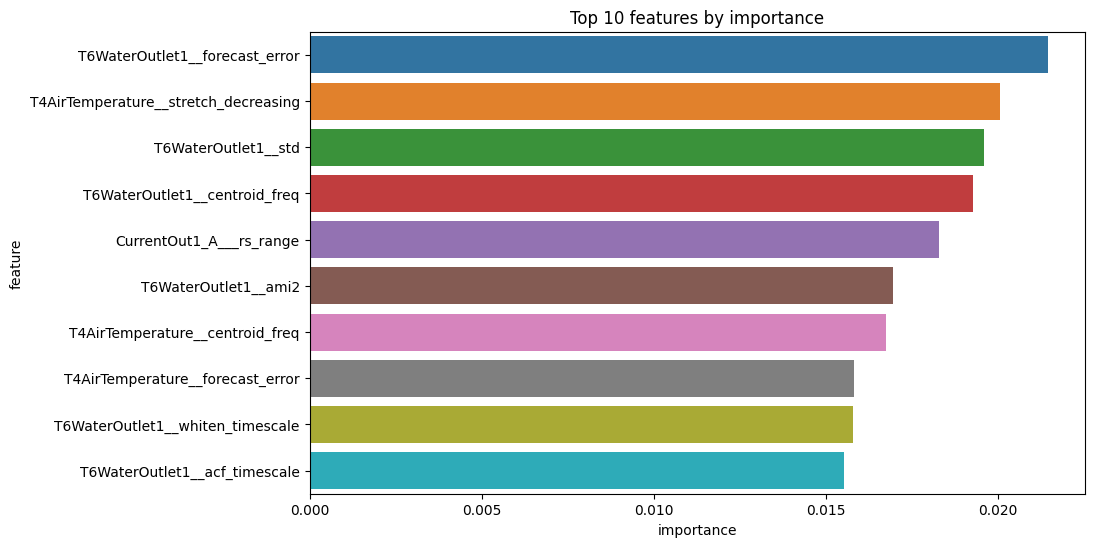

In [68]:
# Show top 10 features on a bar plot

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x="importance", y="feature")
plt.title("Top 10 features by importance")
plt.show()


Top 10 wskazuje wyraźnie, że duży feature importance mają zmienne: T6WaterOutlet1__forecast_error oraz T4AirTemperature__stretch_decreasing możemy teraz zbadać korelację.

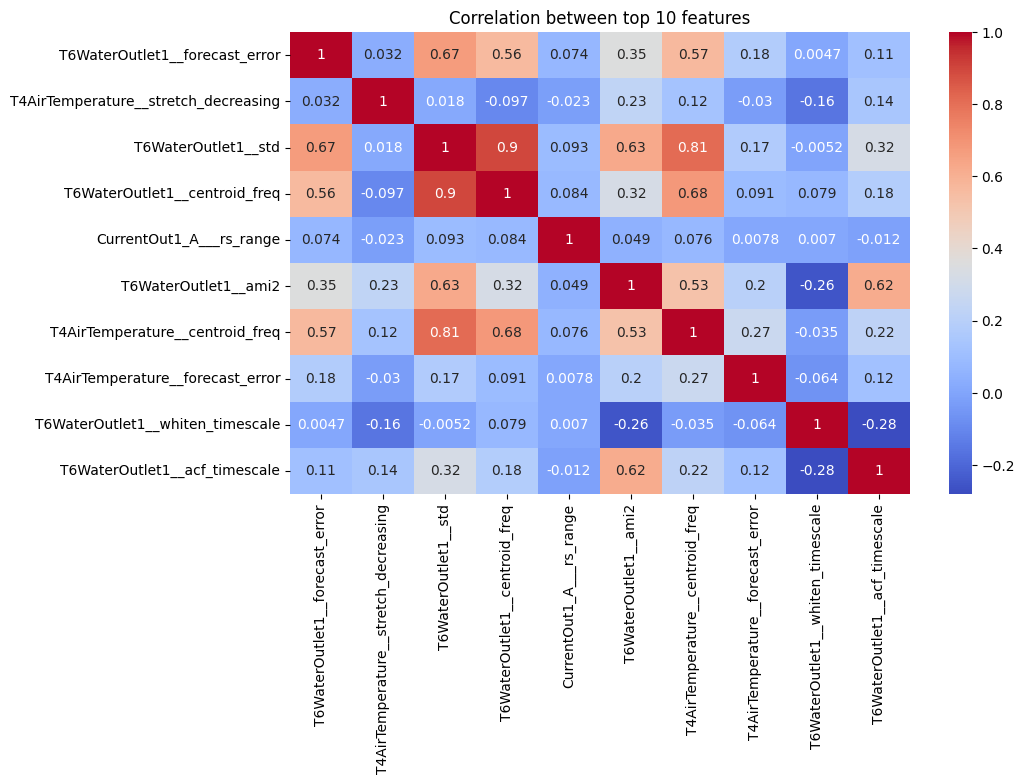

In [74]:
# Calculate the correlation between the top 10 features
top_10_features = feature_importance.head(10)["feature"].values

# Calculate the correlation matrix
correlation_matrix = df[top_10_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation between top 10 features")
plt.show()

Dość ciekawa jest naprawdę wysoka korelacja pomiędzy T6WaterOutlet1__std oraz T6WaterOutlet1__centroid_freq - zatem model powinien też być w stanie się dobrze wytrenować
na jednym z tych dwóch feature'ów. 

In [70]:
# Number of features with importance = 0
zero_importance = feature_importance[feature_importance["importance"] == 0].shape[0]
print(f"Number of features with importance that equals 0: {zero_importance}")


Number of features with importance that equals 0: 29


Można też zaobserwować, że jest aż 29 featurów które mają bardzo mały (wręcz 0) wpływ na model.

# Podsumowanie

Na podstawie zebranych danych można stwierdzić, że cecha, która najbardziej wpłuwa na wynik modelu to "T6WaterOutlet1__forecast_error" - 
czyli błąd prognozy temperatury wody w wyjściu 1. Trzy najważniejsze cechy mają miarę wpływu na wynik modelu powyżej 0.02, co też ostatecznie pokazuje, że model ma sporo
istotnych cech, jednak aż 29 z nich (na 144) nie ma prawie żadnego znaczenia.